Now, we will perform an exploratory analysis of preprocessed data to uncover links between behavioral, self-reported and knowledge data. In particular, we will investigate **How student behavior during the trajectory (as a proxy for metacognitive engagement) relates to self-reported perceptions (e.g., effort, cognitive load, perceived difficulties), and whether these behaviors predict or moderate perceived effectiveness and knowledge gain.**

* Correlations or other predictive relationships between behavioral patterns and:
own effort, cognitive load, learning difficulty, effectiveness, test score
* Clusters or patterns of student behavior during the trajectory (e.g., low engagement vs. high engagement students).
* Does lower behavioral engagement correspond with lower perceived effectiveness and learning gain? This could indicate that students who do less (e.g., skip optional tasks, avoid hints) may also feel they learn less or actually gain less.


In [39]:
import pandas as pd

# Load episodes data
df_ep = pd.read_csv('agg_behavior_metrics.csv')
df_ep.set_index('student_id', inplace=True)

# Load knowledge gain data
df_kno = pd.read_csv('knowledge_clean.csv')
df_kno.set_index('student_id', inplace=True)

# Load self reported data
df_sel = pd.read_csv('self_report_clean.csv')
df_sel.set_index('student_id', inplace=True)

clean_df = pd.concat([df_ep,df_kno,df_sel], join='inner', axis=1)

# Correlation analysis


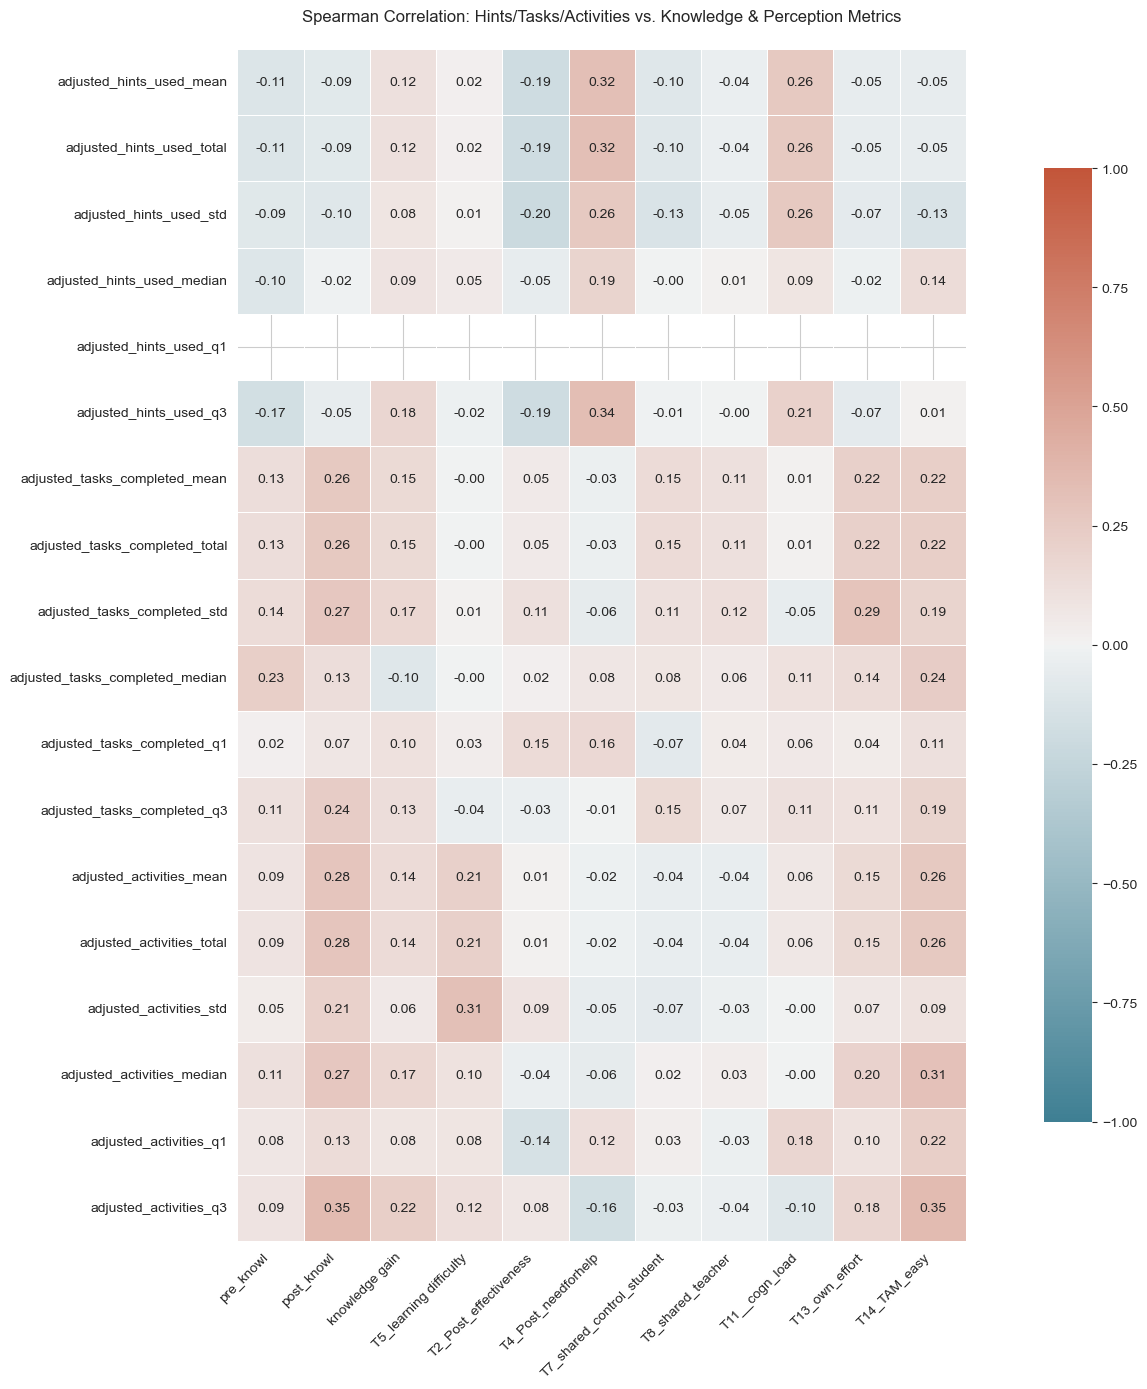

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


group1 = df_ep.columns.to_list()
group2 = df_kno.columns.to_list() + df_sel.columns.to_list()

# 1. Compute correlation matrix
corr_method = 'spearman'  
corr_matrix = clean_df.corr(method=corr_method)

# 2. Filter for cross-group correlations only
cross_corr = corr_matrix.loc[group1, group2]

# 3. Visualization
plt.figure(figsize=(16, 14))

# Create custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True, center='light')

# Heatmap with annotations
ax = sns.heatmap(
    cross_corr,
    vmin=-1, vmax=1, center=0,
    cmap=cmap,
    square=True,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cbar_kws={'shrink': 0.8}
)

# Improve readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title(f'{corr_method.title()} Correlation: Hints/Tasks/Activities vs. Knowledge & Perception Metrics', pad=20)
plt.tight_layout()

# 4. Save and show
#plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Get top correlations (optional)
corr_stack = cross_corr.stack().reset_index()
corr_stack.columns = ['Group1', 'Group2', 'Correlation']
top_pos = corr_stack.sort_values('Correlation', ascending=False).head(5)
top_neg = corr_stack.sort_values('Correlation').head(5)


## Top Correlations
The following table shows top correlation measures.

| Group1                      | Group2                     | Correlation |
|-----------------------------|----------------------------|-------------|
| **Positive Correlations**   |                            |             |
| 186 adjusted_activities_q3  | T14_TAM_easy               | 0.351460    |
| 177 adjusted_activities_q3  | post_knowl                 | 0.350219    |
| 49 adjusted_hints_used_q3   | T4_Post_needforhelp        | 0.335138    |
| 16 adjusted_hints_used_total| T4_Post_needforhelp        | 0.324479    |
| 5 adjusted_hints_used_mean  | T4_Post_needforhelp        | 0.324479    |
| **Negative Correlations**   |                            |             |
| 26 adjusted_hints_used_std  | T2_Post_effectiveness      | -0.204177   |
| 48 adjusted_hints_used_q3   | T2_Post_effectiveness      | -0.191897   |
| 4 adjusted_hints_used_mean  | T2_Post_effectiveness      | -0.190635   |
| 15 adjusted_hints_used_total| T2_Post_effectiveness      | -0.190635   |
| 44 adjusted_hints_used_q3   | pre_knowl                  | -0.167217   |

# Clustering

We will now explore behavioral data to identify patterns/clusters. We will follow the following steps

1. Identify optimal number of cluster
2. Perform clustering using behavioral data (i.e., interactions)
3. Distinguish features contributing the most to clustering
4. Interpret clusters based on top-5 most contributing features


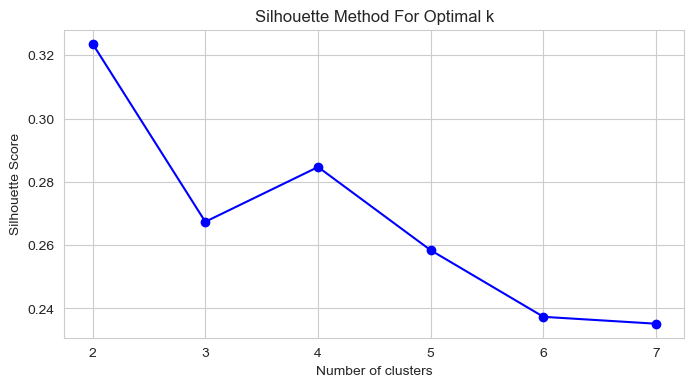

In [48]:
#| label: fig-optimal
#| fig-cap: "Optimal number of clusters"
#| fig-align: center
#| warning: false


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

# Assuming df is your DataFrame with Group 1 features
group1_features = [
    'adjusted_hints_used_mean','adjusted_hints_used_total',
    'adjusted_hints_used_std', 
     'adjusted_hints_used_median',
    'adjusted_hints_used_q1', 'adjusted_hints_used_q3',
    'adjusted_tasks_completed_mean', 'adjusted_tasks_completed_total',
    'adjusted_tasks_completed_std' 
    , 'adjusted_tasks_completed_median',
    'adjusted_tasks_completed_q1', 'adjusted_tasks_completed_q3',
    'adjusted_activities_mean', 'adjusted_activities_total',
    'adjusted_activities_std',
     'adjusted_activities_median',
    'adjusted_activities_q1', 'adjusted_activities_q3'
]

# 1. Preprocess data
X = clean_df[group1_features].copy()

# Handle missing values if any
X = X.dropna()

# Standard scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 2. Determine optimal number of clusters using Silhouette method
silhouette_scores = []
k_range = range(2, 8)  # Testing cluster numbers from 2 to 7

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.grid(True)
plt.show()

In [68]:
# Select optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]


# Perform K-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
clean_df['cluster'] = cluster_labels

# Cluster statistics summary
cluster_stats = clean_df.groupby('cluster')[group1_features].mean().T


The optimal number of clusters is **2** based on Silhouette method. We use that as the value of K=2 in our clustering algorithm which will assign each student record to a cluster. We later use these cluster labels to identify most important features using Random Forest approarch (See @ismaili2014supervised for more info)

@fig-top-5 below shows top-10 important features for clustering.

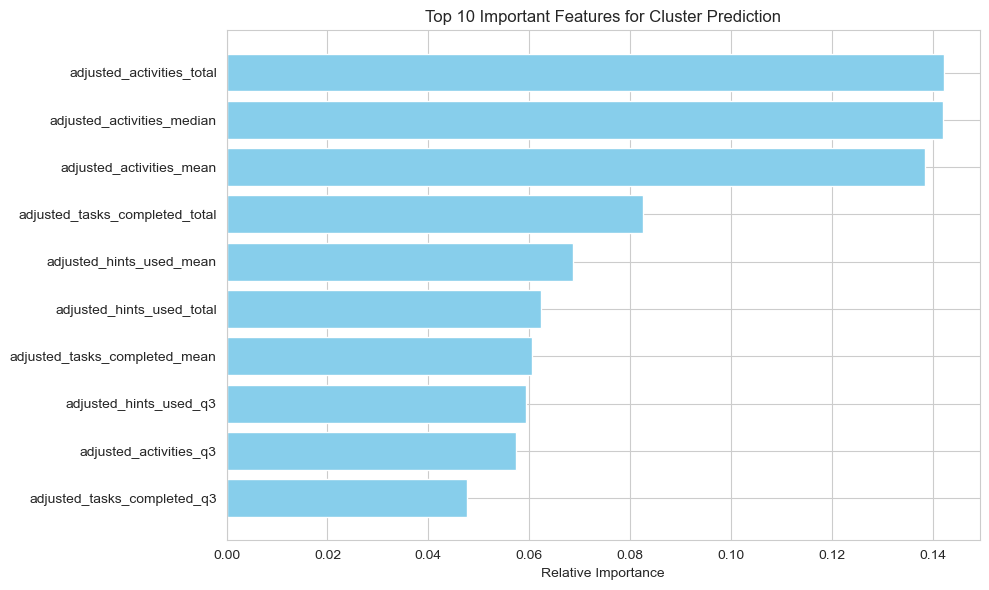

In [52]:
#| label: fig-top-5
#| fig-cap: "Top 10 important features for cluster prediction"
#| fig-align: center
#| warning: false


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare data
X = clean_df[group1_features].copy()
y = clean_df['cluster'].copy()

# Handle missing values if any
X = X.dropna()
y = y.loc[X.index]

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 5 features
features = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title('Top 10 Important Features for Cluster Prediction')
plt.barh(range(10), importances[indices], align='center', color='skyblue')
plt.yticks(range(10), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

# 7. Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)


Now, we will attempt to interpret the two clusters using identified key behavioral features. @fig-cluster_dist shows distribution of those key features across two clusters.

/var/folders/73/znzyp3s516d8sftjt58jzlzw0000gp/T/ipykernel_30330/2212874814.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


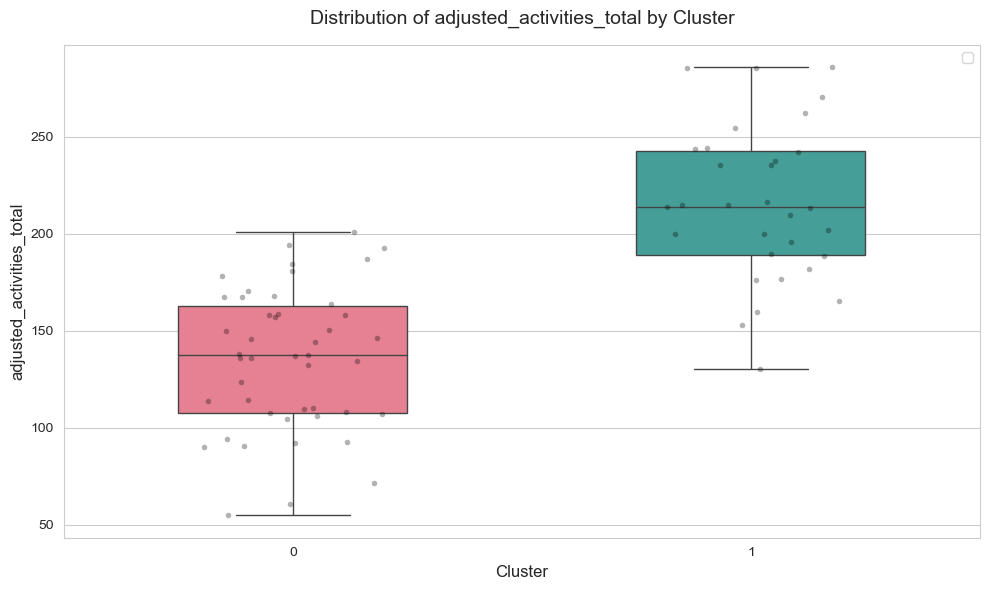

/var/folders/73/znzyp3s516d8sftjt58jzlzw0000gp/T/ipykernel_30330/2212874814.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


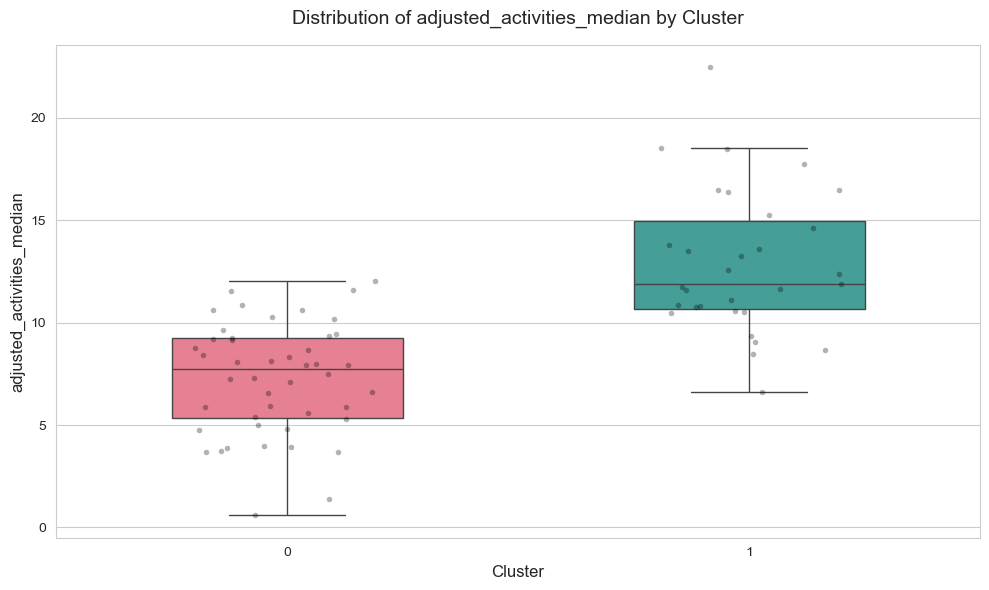

/var/folders/73/znzyp3s516d8sftjt58jzlzw0000gp/T/ipykernel_30330/2212874814.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


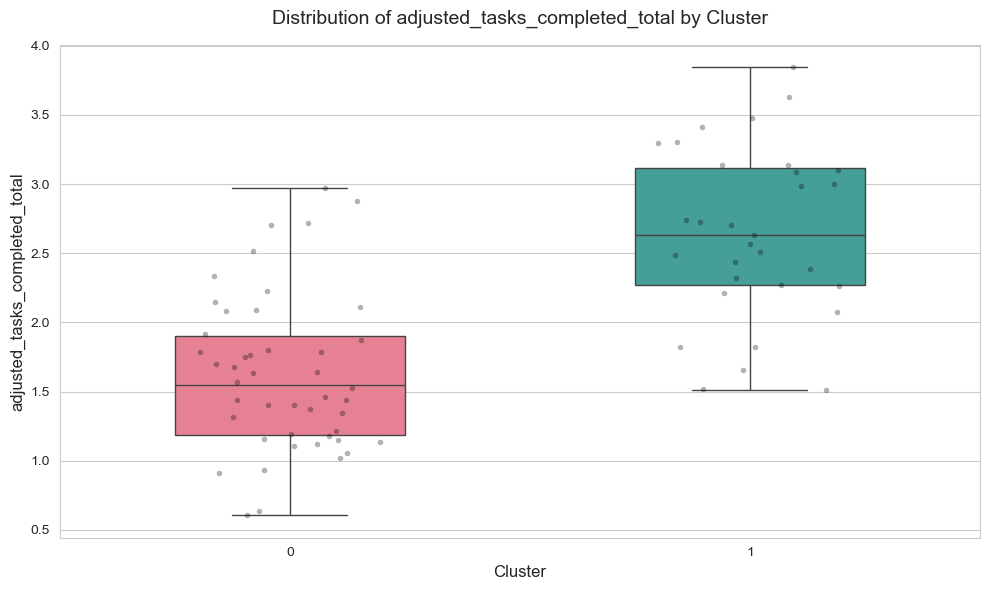

/var/folders/73/znzyp3s516d8sftjt58jzlzw0000gp/T/ipykernel_30330/2212874814.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


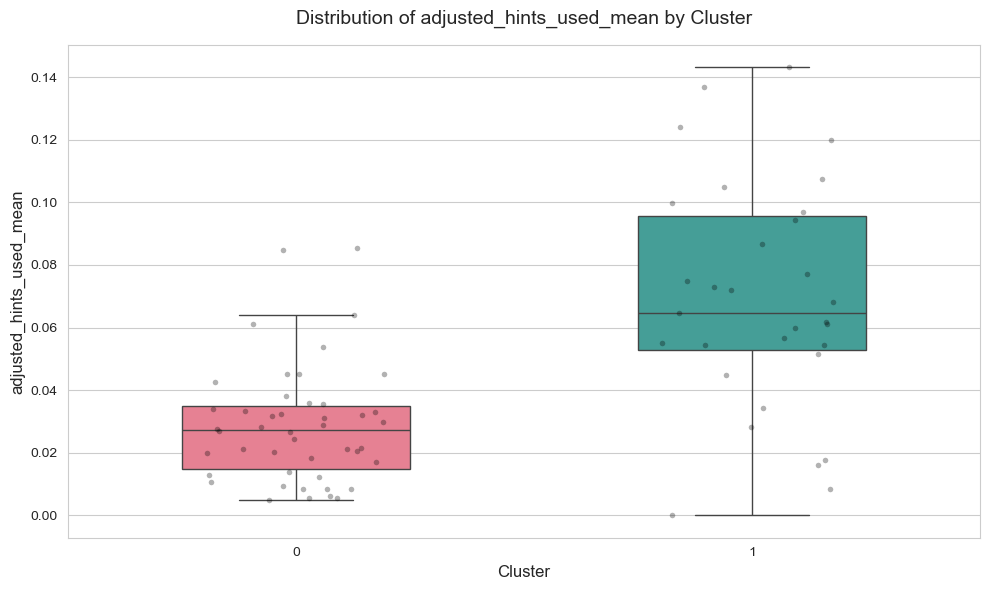

/var/folders/73/znzyp3s516d8sftjt58jzlzw0000gp/T/ipykernel_30330/2212874814.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


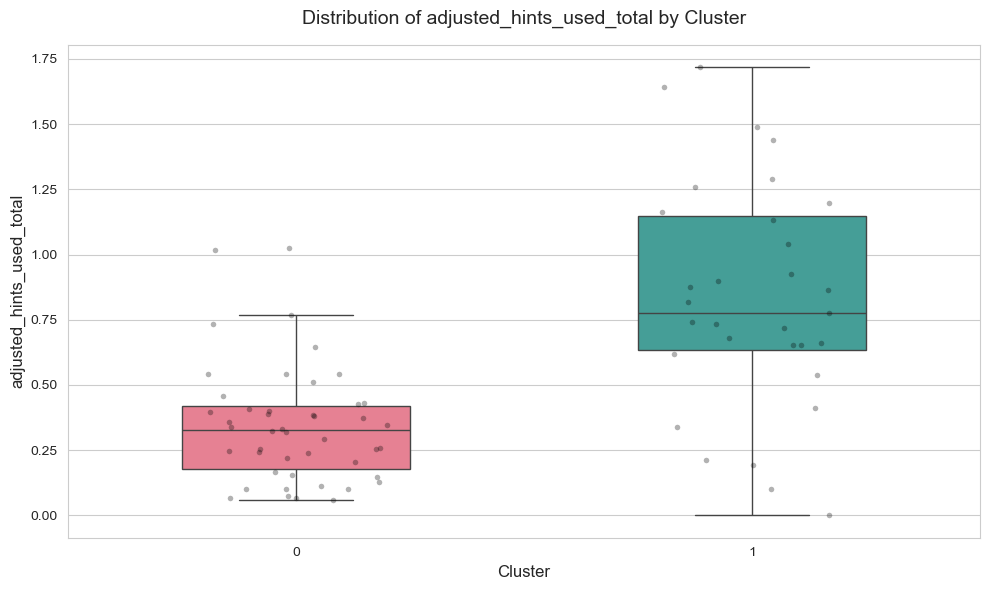

/var/folders/73/znzyp3s516d8sftjt58jzlzw0000gp/T/ipykernel_30330/2212874814.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


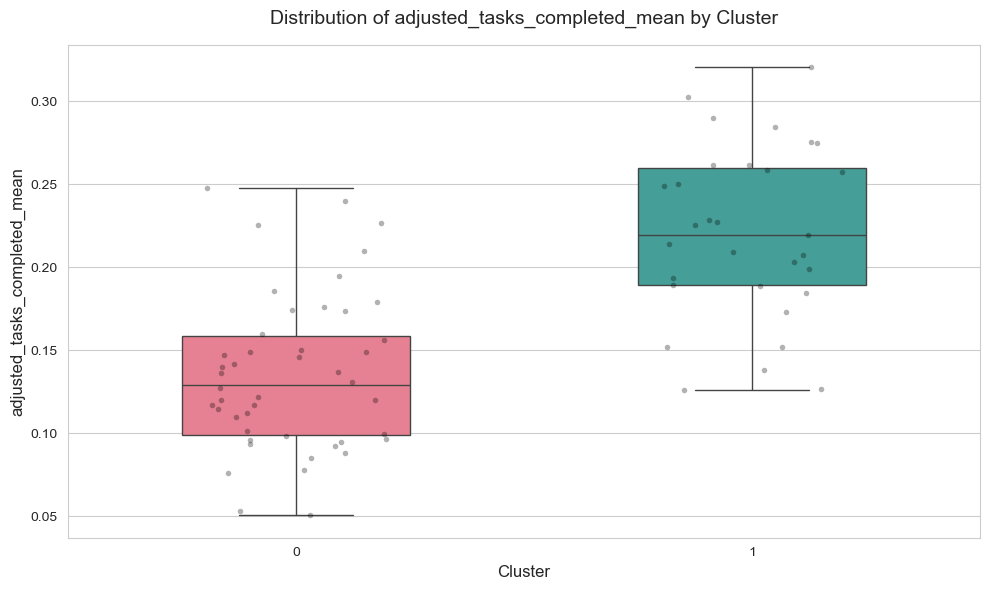

In [64]:
#| label: fig-cluster_dist
#| fig-cap: "Behavioral clusters and metrics distribution"
#| fig-subcap: 
#|   - "Adjusted activities (total)"
#|   - "Adjusted activities (median)"
#|   - "Adjusted task completed (total)"
#|   - "Adjusted hints used (mean)"
#|   - "Adjusted hints used (total)"
#|   - "Adjusted task completed (mean)"
#| warning: false
#| layout-ncol: 2

# Set style
sns.set_style("whitegrid")
palette = sns.color_palette("husl", n_colors=len(clean_df['cluster'].unique()))  


# Features to plot
features = [
    'adjusted_activities_total',
    'adjusted_activities_median',
    'adjusted_tasks_completed_total',
    'adjusted_hints_used_mean',
    'adjusted_hints_used_total',
    'adjusted_tasks_completed_mean',
    
]

for feature in features:
    #| label: f"fig-{feature}"
    #| fig-subcap: f"{feature}"
    plt.figure(figsize=(10, 6))
    
    # Box plot
    ax = sns.boxplot(
        x='cluster',
        y=feature,
        data=clean_df,
        palette=palette,
        width=0.5,
        showfliers=False  # Hide outliers for cleaner visualization
    )
    
    # Add data points
    sns.stripplot(
        x='cluster',
        y=feature,
        data=clean_df,
        color='black',
        alpha=0.3,
        size=4,
        jitter=0.2
    )
    
    # Add annotations
    plt.title(f'Distribution of {feature} by Cluster', fontsize=14, pad=15)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    

    # Add legend only once
    if feature == features[0]:
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
